# Tests using the new data class

In [125]:
import os
import pandas as pd

import sys
sys.path.insert(0, "/home/usuario/project/src")

%load_ext autoreload
%autoreload

from kalmanfiltermotion import KalmanMotionTracker
from dataset import Route

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [75]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(datasets_path, all_datasets[0], "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(datasets_path, all_datasets[0], "info_eval.csv"))

In [76]:
# Angles correction Reduces the MSE from 200 to 66 degrees.
predictions.loc[predictions['pred_angles']>3, 'pred_angles'] = predictions[predictions['pred_angles']>3]['pred_angles'] - 3
predictions.loc[predictions['pred_angles']<-3, 'pred_angles'] = predictions[predictions['pred_angles']<-3]['pred_angles'] + 3

In [77]:
def routes_to_dict(eval_info, predictions):
    ''' Loads (meta)info from disk to memory classes for easy manipulation '''
    routes = dict()
    n_routes = eval_info.shape[0]
    
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        end_i = start_i + current['n_points']
        current_pred = predictions.iloc[start_i:end_i]
        
        route_obj = Route(current['name'], current_pred)
        
        routes[current['name']] = route_obj
            
    return routes

In [78]:
routes_dict = routes_to_dict(eval_info, predictions)

In [84]:
route.routes

,gt_x,gt_y,gt_a,align3d_absolute_x,align3d_absolute_y,align3d_absolute_a,align3d_relative_x,align3d_relative_y,align3d_relative_a,align3d+kf_absolute_x,align3d+kf_absolute_y,align3d+kf_absolute_a,align3d+kf_relative_x,align3d+kf_relative_y,align3d+kf_relative_a
0,20.120384,16.800558,1.584802,20.081619,16.773503,1.734958,20.081619,16.773503,1.734958,20.081619,16.773503,1.734958,20.081619,16.773503,1.734958
1,18.851812,16.911247,1.569748,18.718398,16.882494,1.589671,18.757164,16.909549,1.439515,18.719895,16.882385,1.589816,18.758661,16.909440,1.439660


In [85]:
for key, route in routes_dict.items():
    
    # nn predictions come from neural network! (input data to this script)
    
    # make align3d+kf predictions
    route.run_kalman_filter('align3d')
    
    # make align3d routes
    route.make_absolute_route('align3d')
    route.make_relative_route('align3d')
    
    # make kf routes
    route.make_absolute_route('align3d+kf')
    route.make_relative_route('align3d+kf')
    
    # compute align3d error
    route.compute_rmse_error('align3d_absolute')
    route.compute_rmse_error('align3d_relative')
    
    # compute kf error
    route.compute_rmse_error('align3d+kf_absolute')
    route.compute_rmse_error('align3d+kf_relative')


In [121]:
import matplotlib.pyplot as plt
from matplotlib import patches

#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 8, 8

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = 20,10

In [122]:
def plot_route(route, names=None, arrows=False):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    fig, ax = plt.subplots()
    
    colours=['orange', 'red', 'green', 'blue', 'pink', 'yellow', 'cyan']
    
    ax.plot(route.routes['gt_x'], route.routes['gt_y'], '-ok', color='black')
    for i, name in enumerate(names):
        ax.plot(route.routes[f'{name}_x'], route.routes[f'{name}_y'], '-ok', color=colours[i], label=f'{name} RMSE: {route.trans_error[name]:.4f}')
        
        
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))

    ax.legend(prop={'size': 15})

    # Set title to the plot
    ax.set_title(f"route: {route.name}", size=20)
   

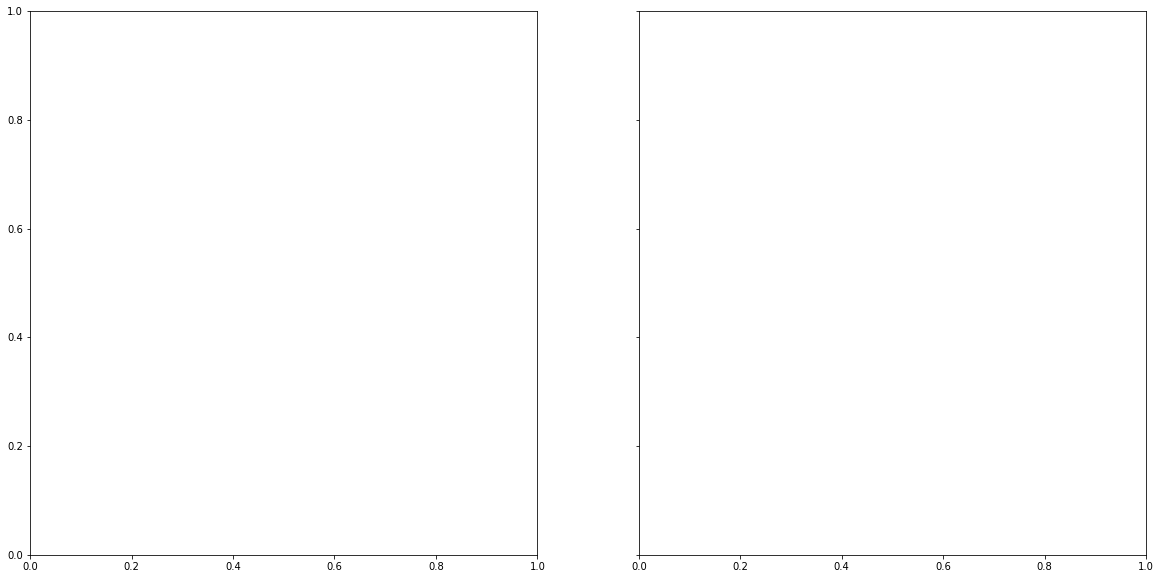

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(20,10),sharex='row', sharey='row')

In [147]:
list(zip(ax.flat, ['relative', 'absolute']))

[(<matplotlib.axes._subplots.AxesSubplot at 0x7fc247eb8350>, 'relative'),
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fc247f66610>, 'absolute')]

In [168]:
def plot_two_route(route, names=None, arrows=False):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    
    # Link axis (?)
    #fig, ax = plt.subplots(1, 2, figsize=(20,10),sharex='row', sharey='row')
    fig, ax = plt.subplots(1, 2, figsize=(20,10))

    
    colours=['orange', 'red', 'green', 'blue', 'pink', 'yellow', 'cyan']
    
    # We build two different axis for relative and absolute
    for axis, motion in zip(ax.flat, ['relative', 'absolute']):
        
        # Always plot ground thruth
        axis.plot(route.routes['gt_x'], route.routes['gt_y'], '-ok', color='black')
        # And plot each route on the axis
        for i, name in enumerate(names):
            name_var = f'{name}_{motion}'
            axis.plot(route.routes[f'{name_var}_x'], route.routes[f'{name_var}_y'], '-ok', color=colours[i], label=f'{name} RMSE: {route.trans_error[name_var]:.4f}')

        # Set axis and legend to axis
        axis.legend(prop={'size': 15})
        axis.set_title(f"route: {route.name} {motion}", size=20)
        
    
    # TODO: fix arrows
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))

    

In [165]:
i = 10

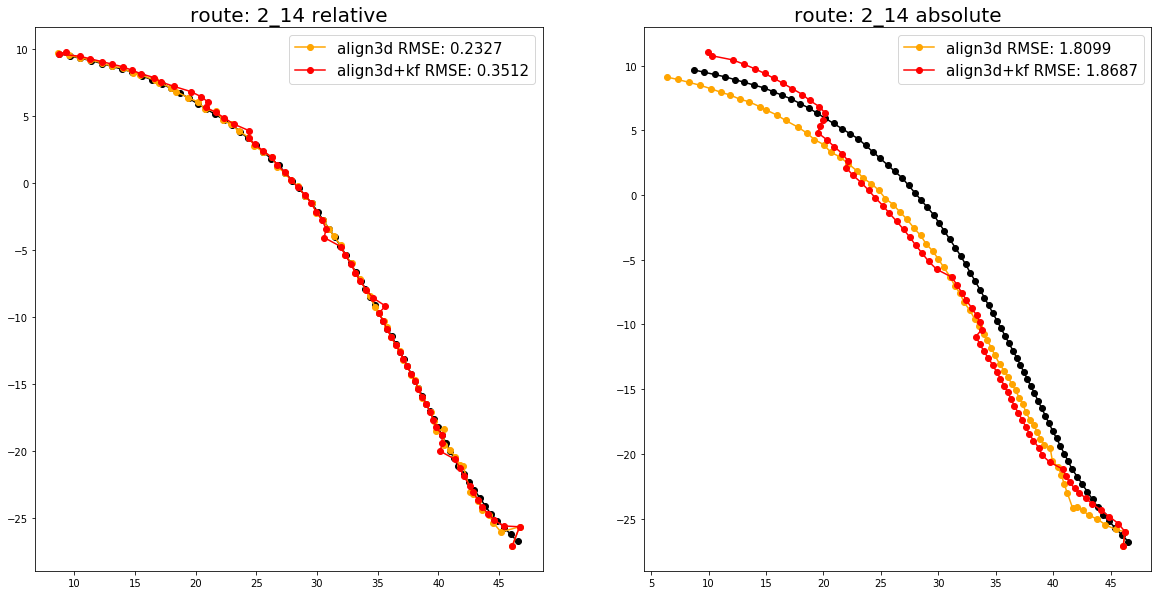

In [171]:
plot_two_route(routes_dict[list(routes_dict.keys())[i]], names=['align3d', 'align3d+kf'])
i += 1

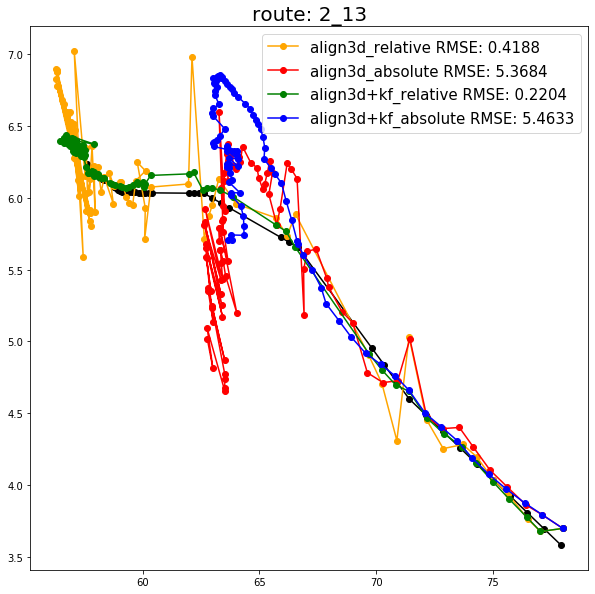

In [89]:
plot_route(routes_dict[list(routes_dict.keys())[i]], names=['align3d_relative', 'align3d_absolute',\
                                                           'align3d+kf_relative', 'align3d+kf_absolute'])
i += 1